In [82]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
import statsmodels.api as sm



matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import loadResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
EXPERIMENT_NAME = 'Experiment_template'

## Set configuration

In [3]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg
cfg.use_default_data = True
cfg.saved_index=6

## Obtain Data
Obtain the simulated $y$ and $f$

Theoretical optimal mse for f, y, enc: 19.720
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Tanh()
    (linear_4): Linear(in_features=80, out_features=100, bias=True)
    (activation_4): Identity()
  )
)
(10, 100) (1024, 100) (15350, 100)


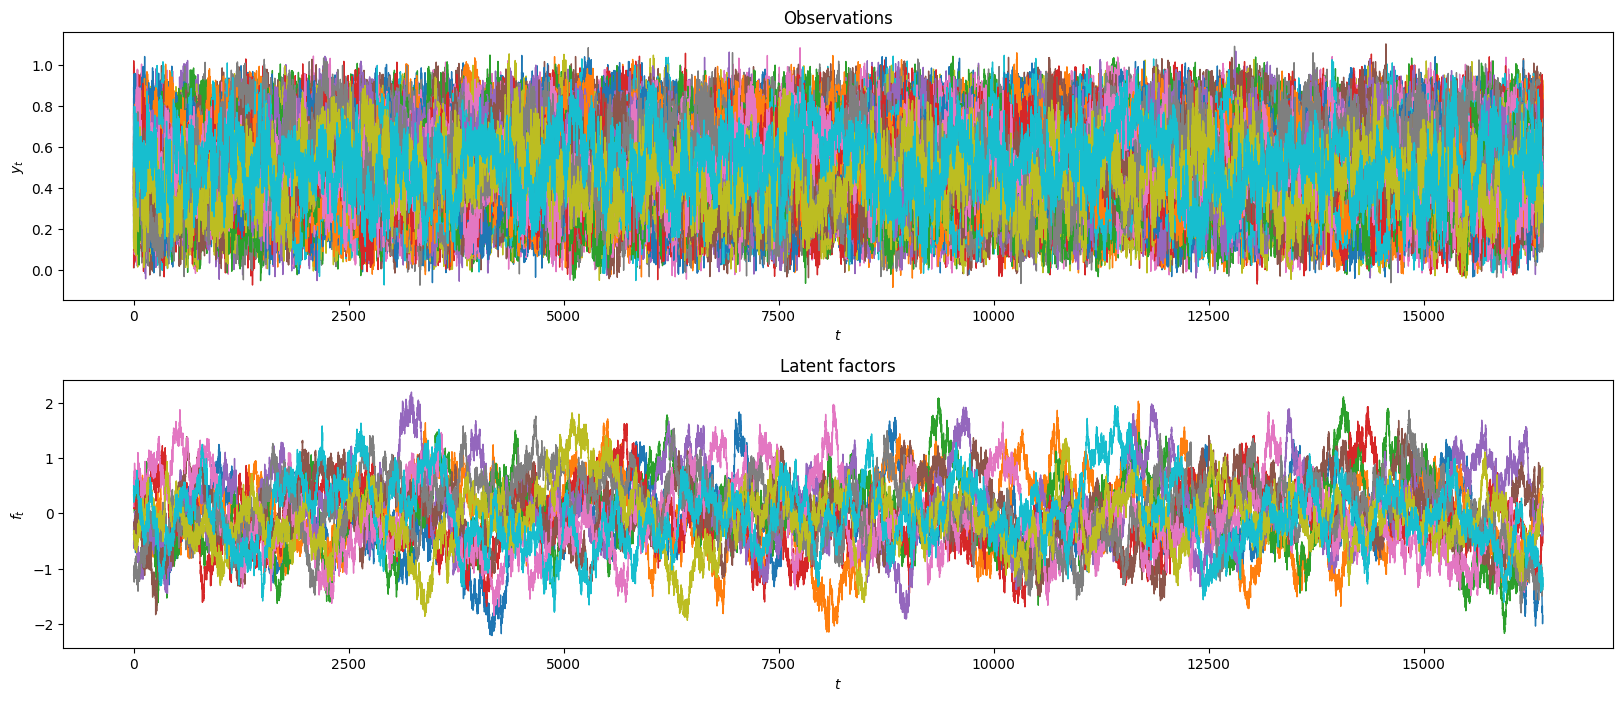

In [5]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim,5, 10,20,40,50,60,70,80,90, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=True, use_xavier=True)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_13615/1696415828.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bs)
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_13615/1696415828.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bs)
/var/folders/sp/mlrrd77d24gb2c

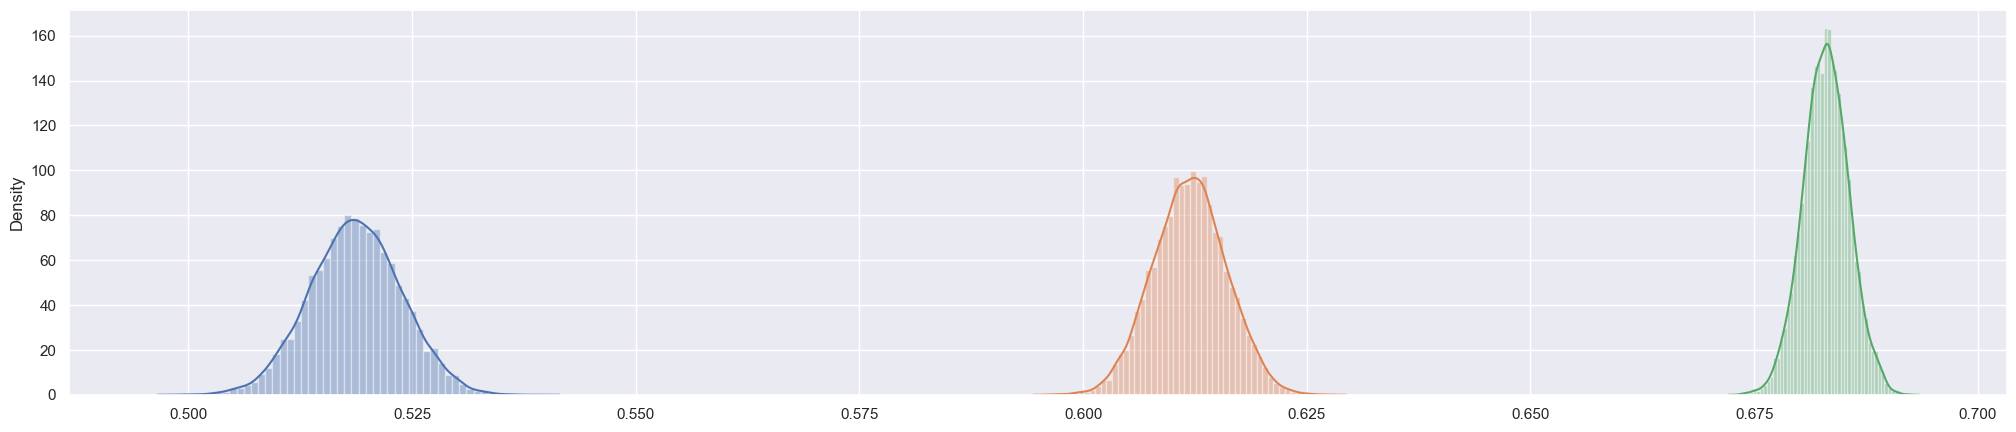

In [79]:
from sklearn.decomposition import PCA
from evaluation import bootstrapCCA
mean = {}
ci = {}
bs_mean = {}
for T_train in [100,1000,10000]:
    f_train_ = f[0:T_train]
    f_val_ = f[T_train:T_train+cfg.T_val]
    f_test_ = f[T_train+cfg.T_val:]

    y_train_ = y[0:T_train]
    y_val_ = y[T_train:T_train+cfg.T_val]
    y_test_ = y[T_train+cfg.T_val:]
    #print(f_train_.shape)

    pca = PCA(n_components=cfg.factor_dim)
    f_train_hat = pca.fit_transform(y_train_)
    f_val_hat = pca.transform(y_val_)
    cancorr = CanCorr(f_train_hat, f_train_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on train data: {cc}")

    f_test_hat = pca.transform(y_test_)
    y_test_hat = pca.inverse_transform(f_test_hat)
    mse = np.mean((y_test_hat-y_test_)**2)
    cancorr = CanCorr(f_test_hat, f_test_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on test data: {cc}")
    mean[str(T_train)] = cc

    
    bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test_, n_bootstrap=10000, n_sample=2000)
    sns.distplot(bs)
    ci[str(T_train)]  = np.quantile(bs, [0.025, 0.975])
    bs_mean[str(T_train)] = np.mean(bs)

{'100': 0.5174522215103441, '1000': 0.6112100651534338, '10000': 0.6816692760251766}


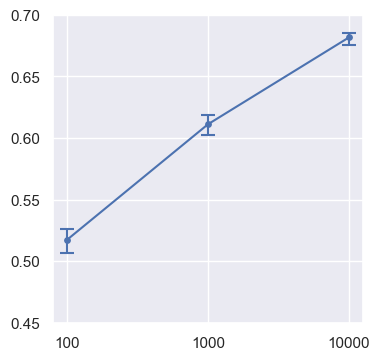

In [81]:
print(mean)
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.ylim(0.45,0.7)
for t, tci in ci.items():
    error = np.abs(tci-mean[t])
    plt.errorbar(x=t, y=mean[t],yerr=error[::-1][:,None], capsize=5, c='C0', capthick=1.5)
plt.scatter(x=mean.keys(),y=mean.values(), s=15, marker='o')
plt.plot(mean.keys(),mean.values())

/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_13615/1408141693.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bs)
/var/folders/sp/mlrrd77d24gb2cktbf3r6tpc0000gn/T/ipykernel_13615/1408141693.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bs)
/var/folders/sp/mlrrd77d24gb2c

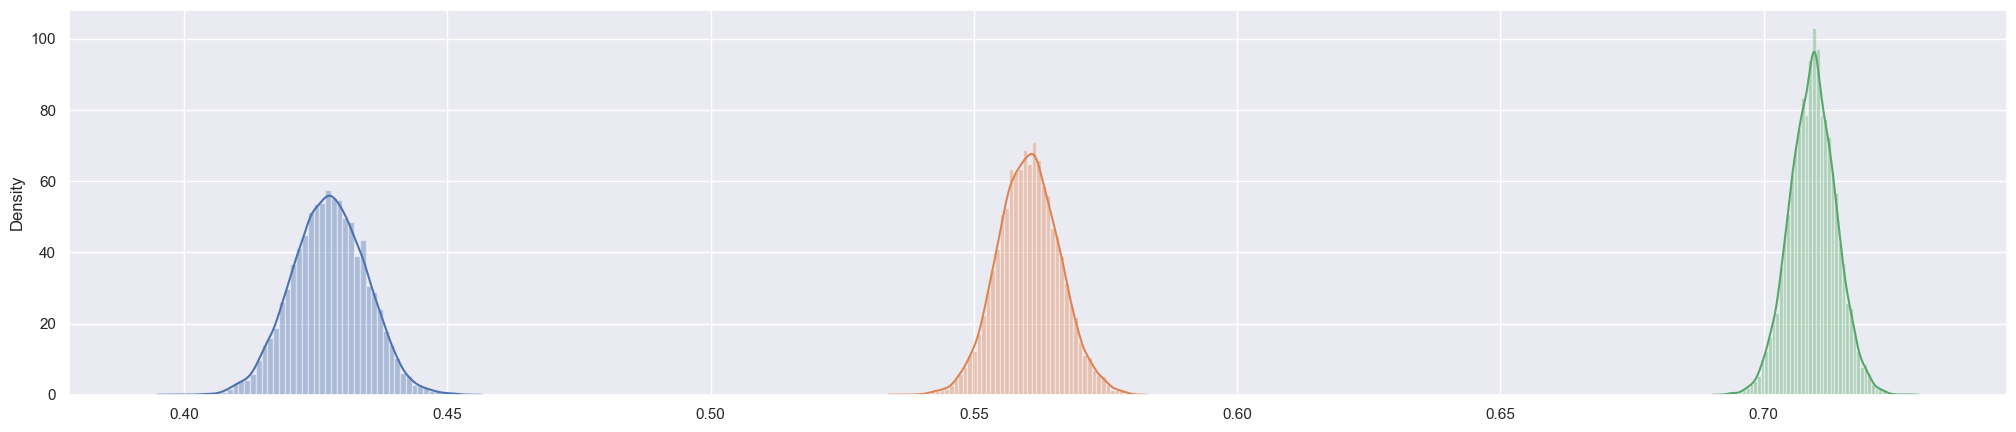

In [101]:
models = {100:'1_OverParametrization_T100_05142023_00:24:33', 1000: '3_OverParametrization_T1000_05142023_00:29:28', 10000:'2_OverParametrization_T10000_05142023_13:25:25'}
mean_ae = {}
ci_ae = {}
bs_mean_ae = {}

for T_train, experimentName in models.items():
    train_hist, mod, cfg = loadResults(dgpIndex=6, name=experimentName)
    f_train_ = f[0:T_train]
    f_val_ = f[T_train:T_train+cfg.T_val]
    f_test_ = f[T_train+cfg.T_val:]

    y_train_ = y[0:T_train]
    y_val_ = y[T_train:T_train+cfg.T_val]
    y_test_ = y[T_train+cfg.T_val:]
    #print(f_train_.shape)

    f_train_hat = mod.enc(torch.Tensor(y_train_).float()).detach().numpy()
    f_val_hat =  mod.enc(torch.Tensor(y_val_).float()).detach().numpy()
    cancorr = CanCorr(f_train_hat, f_train_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on train data: {cc}")

    f_test_hat =  mod.enc(torch.Tensor(y_test_).float()).detach().numpy()
    y_test_hat =  mod(torch.Tensor(y_test_).float()).detach().numpy()
    mse = np.mean((y_test_hat-y_test_)**2)
    cancorr = CanCorr(f_test_hat, f_test_)
    cc = np.mean(cancorr.cancorr)
    #print(f"cc on test data: {cc}")
    mean_ae[str(T_train)] = cc

    
    bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test_, n_bootstrap=10000, n_sample=1000)
    sns.distplot(bs)
    ci_ae[str(T_train)]  = np.quantile(bs, [0.025, 0.975])
    bs_mean_ae[str(T_train)] = np.mean(bs)

{'100': 0.4200754941172404, '1000': 0.5561176655286482, '10000': 0.7085173045471871}


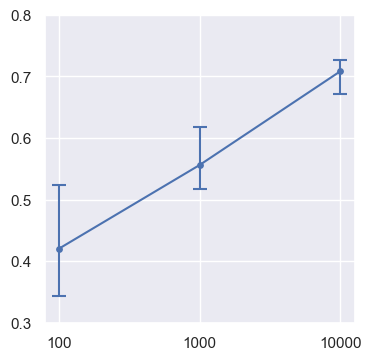

In [102]:
print(mean_ae)
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.ylim(0.3,0.8)
for t, tci in ci_ae.items():
    error = np.abs(tci-mean[t])
    plt.errorbar(x=t, y=mean_ae[t],yerr=error[::-1][:,None], capsize=5, c='C0', capthick=1.5)
plt.scatter(x=mean_ae.keys(),y=mean_ae.values(), s=15, marker='o')
plt.plot(mean_ae.keys(),mean_ae.values())

{'100': 0.4200754941172404, '1000': 0.5561176655286482, '10000': 0.7085173045471871}


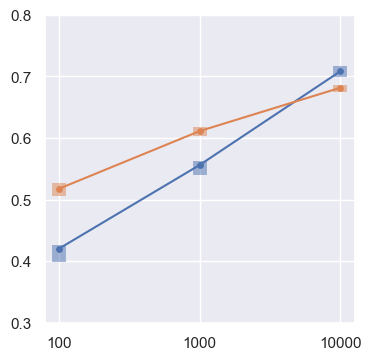

In [118]:
print(mean_ae)
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.ylim(0.3,0.8)
for t, tci in ci_ae.items():
    error = np.abs(tci-mean_ae[t])
    plt.errorbar(x=t, y=mean_ae[t],yerr=error[::-1][:,None], capsize=0, c='C0', capthick=0, elinewidth=10, alpha=0.5)
plt.scatter(x=mean_ae.keys(),y=mean_ae.values(), s=15, marker='o')
plt.plot(mean_ae.keys(),mean_ae.values())

#add other values
for t, tci in ci.items():
    error = np.abs(tci-mean[t])
    plt.errorbar(x=t, y=mean[t],yerr=error[::-1][:,None], capsize=0, c='C1', capthick=1.5, alpha=0.5, elinewidth=10)
plt.scatter(x=mean.keys(),y=mean.values(), s=15, marker='o', c='C1')
plt.plot(mean.keys(),mean.values(), c= 'C1')